            Churn     tenure  MonthlyCharges  TotalCharges
cluster                                                   
0        0.074098  30.653115       21.116098    665.924656
1        0.141569  46.130748       79.565645   3823.638593
2        0.475463  15.609360       71.143240   1154.776666
3        0.102952  62.115821       88.049129   5485.973202


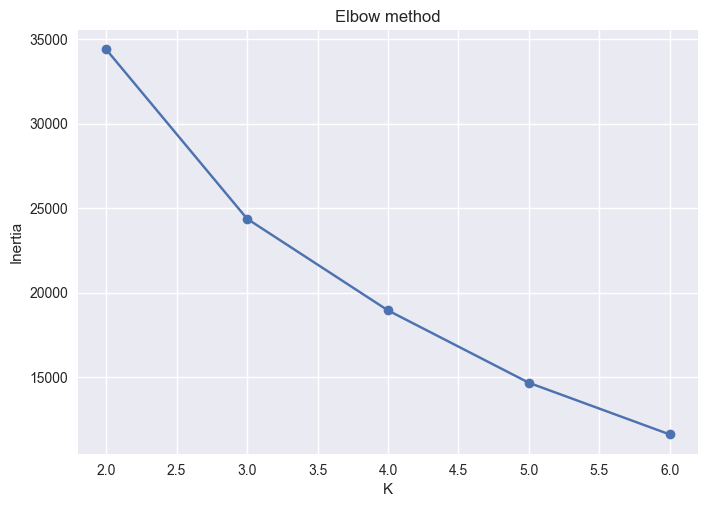

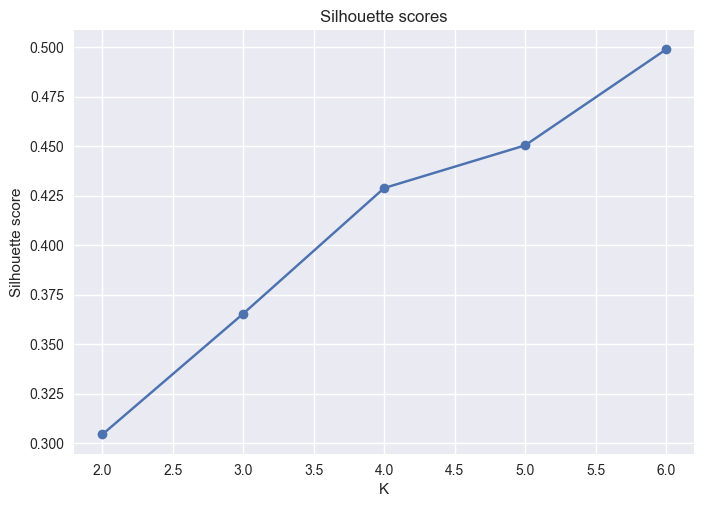

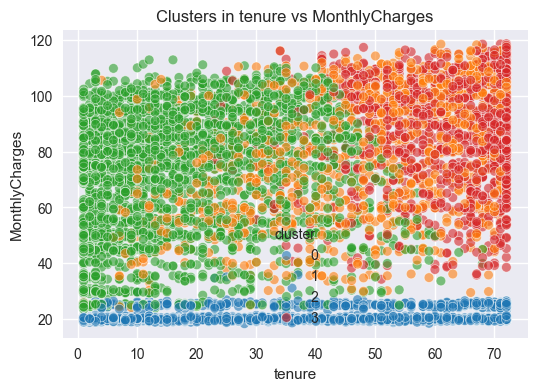

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-v0_8")

# 1. Load cleaned data and encode
df = pd.read_csv("../data/processed/telco_cleaned.csv")

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 2. Choose features for clustering
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Add some important service/contract indicators
cluster_features += [col for col in df_encoded.columns if "Contract_" in col]
cluster_features += [col for col in df_encoded.columns if "InternetService_" in col]

X_cluster = df_encoded[cluster_features].copy()

# 3. Scale features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 4. Decide K (elbow + silhouette)
inertias = []
sil_scores = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_cluster_scaled, labels))

plt.plot(K_range, inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.savefig("../figures/kmeans_elbow.png", bbox_inches="tight")

plt.figure()
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores")
plt.savefig("../figures/kmeans_silhouette.png", bbox_inches="tight")

# 5. Fit final KMeans (choose K, e.g. 4)
k_opt = 4
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_cluster_scaled)

df_clusters = df.copy()
df_clusters['cluster'] = clusters

# 6. Cluster profiles
cluster_profile = df_clusters.groupby('cluster').agg({
    'Churn': 'mean',
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean'
})
print(cluster_profile)

# 7. Visualize clusters in tenure vs MonthlyCharges
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df_clusters,
    x='tenure', y='MonthlyCharges',
    hue='cluster', palette='tab10', alpha=0.6
)
plt.title("Clusters in tenure vs MonthlyCharges")
plt.savefig("../figures/kmeans_scatter.png", bbox_inches="tight")
